In a previous exercise we plotted the density of states from the DOSCAR file.  However, the result from the actual VASP computation can only be a discrete spectrum of energy eigenvalues (like we read from the EIGENVAL file for the band structure plot), so VASP has to perform some kind of post-processing on the energy spectrum to get the DOS.  This is called [smearing](https://cms.mpi.univie.ac.at/wiki/index.php/ISMEAR) or [Kernel Density Estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation).  The goal is to transform a discrete set of values $\{e_i\}$ into a continuous density $p(e)$ and the basic idea is to place a small smeared out function, the kernel, at each point $e_i$ and then sum over all of them to estimate $p(e)$.

Let's start with the kernel, in our case a simple, normalized gaussian
\begin{equation}
K(e; e_i, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp{ 
    \left\{ -\frac{1}{2}\frac{ (e - e_i)^2 }{\sigma^2} \right\}
},
\end{equation}
that is centered on $e_i$ and of width $\sigma$.  The kernel should always be normalized to one, because we want the final density to be normalized to the number of states in the system for obvious reasons.  Then we define the KDE as
$$
p(e; \sigma) = \sum_i K(e; e_i, \sigma),
$$
where the smearing width $\sigma$ is an open parameter (in VASP this is controlled by the tag `SIGMA`) you can play around with.

To get started let's plot a single gaussian first and then figure out how to do the sum.

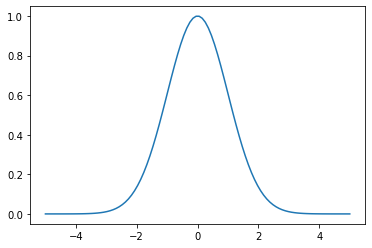

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-5, 5, 100)
plt.plot(x, np.exp(-x**2/2))

Numpy defines arrays that can be used in arithmetic expressions like scalars, but apply the operations to all their elements.

We'll make a function that also takes care of the normalized of the gaussian for us

In [9]:
def gaussian(e, ei, s):
    return np.exp( -0.5 * (e - ei)**2 / s**2 ) / np.sqrt(2 * np.pi * s**2)

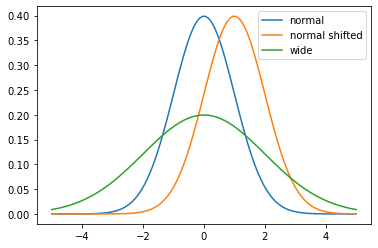

In [11]:
plt.plot(x, gaussian(x, 0, 1), label = 'normal')
plt.plot(x, gaussian(x, 1, 1), label = 'normal shifted')
plt.plot(x, gaussian(x, 0, 2), label = 'wide')
plt.legend()

Now with this write a function that takes a list of energy eigenvalues and a list of sample points and computes the corresponding KDE on it.

In [13]:
def kde(samples, spectrum):
    pass

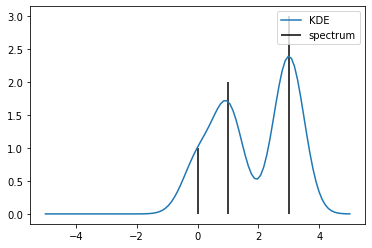

In [35]:
def kde(samples, spectrum, sigma = 1):
    K = np.zeros_like(samples)
    for ei in spectrum:
        K += gaussian(samples, ei, sigma)
        
    return K

plt.plot(x, kde(x, [0, 3, 3, 3, 1, 1], .5), label = 'KDE')
plt.vlines([0, 1, 3], 0, [1, 2, 3], label = 'spectrum')
plt.legend()

Now that we can compute the KDE, we can look into how to get the energy spectrum.  We have to read the energies from the same files as before, so it makes only sense to use the functions we have written for that in the last notebook.

In [16]:
def read_paragraph(file):
    """Read a paragraph from the given file."""
    
    lines = []       # we'll save all the lines in a list; [] creates an empty one
    
    while True:
        new = file.readline()
        if new == '\n' or new == '': # when we've reached the end of the file, readline() will return the empty string ''
            break
        else:
            lines.append(new)
            
    return lines

def read_meta(paragraph):
    """
    Read number of eigenvalues and k points from given paragraph.  
    Must be given the first paragraph of EIGENVAL file.
    """
    
    line = paragraph[-1]  # index -1 is always the last element of a list, -2 the second to last and so on
    elems = line.split()  # split the whole line into sub strings on whitespace ("hello world".split() -> ["hello", "world"])
    
    ne = int(elems[0])    # convert from strings to integers
    nk = int(elems[1])
    
    return ne, nk

However, since we're not interested in bands anymore, we can simplify the last part a little bit and read all the energy eigenvalues into a single list.  There is one important difference; previously we neglected the k point coordinates and the associated weights, because we didn't compute any averages.  However, the DOS is an average of the full Brillouin zone, so we have take the weight correctly into account.  Start by writing a function that reads a single paragraph and returns all energies in the paragraph together with their weight.

In [26]:
def read_kpoint(paragraph):
    pass

In [44]:
def read_kpoint(paragraph):
    line = paragraph[0]              # first line contains k point coordinate and weight
    weight = float(line.split()[-1]) # the weight is the last entry on the first line
    
    energies = []
    for line in paragraph[1:]:
        energy = float(line.split()[1])
        energies.append( [energy, weight] )
        
    return energies

Now given this function and the others for reading the EIGENVAL file, write a function that reads all paragraphs from a file, calls `read_kpoint()` on them then adds all the lists together and returns that.

In [58]:
def read_spectrum(file):
    
    p = read_paragraph(file)
    ne, nk = read_meta(p)
    
    E = []
    for i in range(nk):
        p = read_paragraph(file)
        E += read_kpoint(p)
        
    return E

In [59]:
f = open('EIGENVAL.dos', 'r')
E = read_spectrum(f)
f.close()

In [48]:
def kde_weighted(samples, ewi, sigma):
    K = np.zeros_like(samples)
    for ei, wi in ewi:
        K += wi * gaussian(samples, ei, sigma)
    
    return K

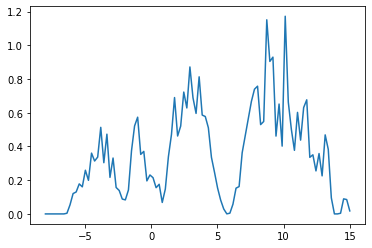

In [55]:
es = np.linspace(-8, 15, 100)
plt.plot(es, kde_weighted(es, E, .1))